In [1]:
%matplotlib inline

from scipy.misc     import imsave
from keras          import metrics
from PIL            import Image

import tensorflow as tf
import keras
from keras import layers
from keras.models                      import Model, load_model, Sequential
from keras.applications.vgg16          import VGG16
from keras.applications.vgg16          import decode_predictions
from keras.utils.np_utils              import to_categorical

import keras.backend     as K
import numpy             as np
import matplotlib.pyplot as plt

from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod


Using TensorFlow backend.


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
def limit_mem():
    cfg                          = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config = cfg))

In [4]:
limit_mem()

In [5]:
def create_title(category, proba):
    return '"%s" %.1f%% confidence' % (category.replace('_', ' '), proba * 100) 

In [6]:
def generate_title(model, array):
    prediction = model.predict(array)
    _, category, proba = decode_predictions(prediction)[0][0]
    
    return create_title(category, proba)

In [7]:
filename = '../../Images/stop2.jpeg'

# Goal

The goal of this notebook is to implement the "fast gradient sign method" presented in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572). This method is used to modify classical samples that a deep neural network trained classification will fail to classify properly.

![fgsm idea](http://karpathy.github.io/assets/break/breakconv.png "Fast Gradient Sign Method")

The idea of this method is to take a sample, ask the network to classify it, compute the gradient of the loss in function of the input pixels and update the picture by a small amount in the direction of the gradient. This direction is opposite to the one that would increase the score for the correct class.

# VGG loading

(1, 100, 100, 3)


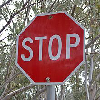

In [8]:
original_pic   = Image.open(filename).resize((100, 100))
original_array = np.expand_dims(np.array(original_pic), 0)
print(original_array.shape)
original_pic

We transform the image according to the VGG16 requirements. It consists in substracting the mean value for each channel and reversing the order of the channels. 

In [9]:
imagenet_mean      = np.array([123.68, 116.779, 103.939], dtype = np.float32)
#preprocess         = lambda x: (x - imagenet_mean)[:, :, :, ::-1]
#deprocess          = lambda x: (x[:, :, :, ::-1] + imagenet_mean)

preprocess         = lambda x: (x - imagenet_mean)
deprocess          = lambda x: (x + imagenet_mean)
preprocessed_array = preprocess(original_array)
#preprocessed_array = preprocessed_array.reshape(1,3,48,48)
print(preprocessed_array.shape)

#model              = load_model('../../Models/VGG16/model_pur_transfert_GTSRB.h5')



#model.summary()


(1, 100, 100, 3)


In [10]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(include_top=False , weights="imagenet", input_shape=(100, 100, 3))
#vgg16.summary()

In [11]:
#inputs = layers.Input(shape=(100,100,3),name="Custom_input")

#x = vgg16.layers[1](inputs)
#for vgg16_layer in vgg16.layers[2:]:
 #   print(vgg16_layer)
  #  x = vgg16_layer(x)


x = vgg16.output
x = layers.Flatten()(x)
x = layers.Dense(units=256, activation="relu", name="Dense_1")(x)
x = layers.Dropout(rate=0.5, name="Dropout_Dense_1")(x)
x = layers.Dense(units=512, activation="relu", name="Dense_2")(x)
x = layers.Dropout(rate=0.5, name="Dropout_Dense_2")(x)
outputs = layers.Dense(units=43, activation="softmax", name="Softmax")(x)

                      
model = Model(inputs=vgg16.input, outputs=outputs)

In [12]:
for layer in vgg16.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#model.summary()

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model_plot.png', show_layer_names=True)

Now let's ask the network what he sees in the picture. 

In [14]:
#pred = model.predict(preprocessed_array).argmax()
pred = model.predict(original_array).argmax()
#print(*[p[1:] for p in decode_predictions(pred)[0]], sep = '\n')
print(pred)

4


# Adversarial example generation

Now we try to confuse the network by modifying the brocoli picture. We first compute the derivatives of the loss function according to the pixels of the image.

In [15]:
target_idx      = model.predict(original_array).argmax()
target          = to_categorical(target_idx, 43)
target_variable = K.variable(target)
loss            = metrics.categorical_crossentropy(model.output, target_variable)
gradients       = K.gradients(loss, model.input)
get_grad_values = K.function([model.input], gradients)
grad_values     = get_grad_values([original_array])[0]

As mentioned in the article, we will just use the signs of the derivatives.

In [16]:
grad_signs = np.sign(grad_values)

Now we multiply these values by a very small number and add them to the pixel values of the original image. The conversion to uint8 is necessary to get a proper display using imshow ([Stackoverflow](https://stackoverflow.com/questions/39925420/bizzare-matplotlib-behaviour-in-displaying-images-cast-as-floats)). We also clip the values to the interval [0, 255] to get a valid image.

In [17]:
#fgsm_params = {
  #    'eps': 0.3,
  #    'y': 14,
  #    'y_target': 10,
  #   'clip_min': 0.,
  #   'clip_max': 1.
  #}

fgsm_params = {
      'eps': 0.3,
      'clip_min': 0.,
      'clip_max': 1.
  }

# Initialize the Fast Gradient Sign Method (FGSM) attack object
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap)

#fgsm = FastGradientMethod(wrap, **fgsm_params)
adv_clever = fgsm.generate(tf.convert_to_tensor(original_array,dtype=np.float32), **fgsm_params)
np_adv_clever = K.eval(K.variable(adv_clever))
pred_adv_clever = model.predict(np_adv_clever).argmax()
print(pred_adv_clever)

20


In [18]:
modified_array  = preprocessed_array + np_adv_clever
deprocess_array = np.clip(deprocess(modified_array), 0., 255.).astype(np.uint8)

In [19]:
#title_original     = generate_title(model, preprocessed_array)
#title_perturbation = generate_title(model, perturbation)
#title_modified     = generate_title(model, modified_array)

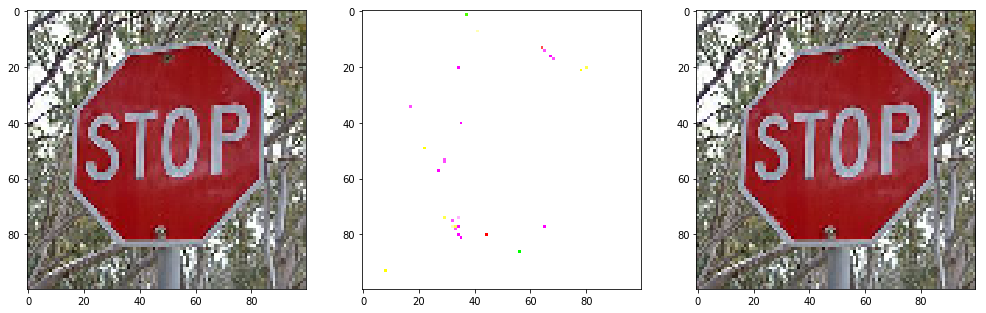

In [20]:
plt.figure(figsize = (17, 17))
plt.subplot(1, 3, 1)
plt.imshow(original_array[0])
#plt.title(title_original)
plt.subplot(1, 3, 2)
plt.imshow(np_adv_clever[0])
#plt.title(title_perturbation)
plt.subplot(1, 3, 3)
plt.imshow(deprocess_array[0])
#plt.title(title_modified)

In [21]:
print("Clean prediction : %d"%(pred))
print("Adversarial prediction : %d" %(pred_adv_clever))

Clean prediction : 4
Adversarial prediction : 20
